In [1]:
TRAIN_SPLIT = 300#300#300000
BUFFER_SIZE = 1000#100#10000#100#10000
BATCH_SIZE = 32#128#256##256
EVALUATION_INTERVAL = 2#200
EPOCHS = 10

past_history = 70#0#720
future_target = 7#72
STEP = 1#6#6

features_considered = ['col1', 'col2', 'col3']

In [2]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import utils_lstm as utils
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

dates = pd.to_datetime(pd.date_range('2018-02-13', periods=400, freq='MIN', name='date'), errors='coerce') # freq='T'
col1 = np.arange(len(dates)) * 1 # np.random.randn(len(dates))
col2 = np.array([np.sin(i/10) for i in range(1,(len(dates)+1))]) * 2 # np.random.randn(len(dates))
col3 = np.array([np.sin(i/50) for i in range(1,(len(dates)+1))]) * 3 # np.random.randn(len(dates))
df = pd.DataFrame({'col1':col1,'col2':col2,'col3':col3}, index=dates)

features = df[features_considered]
features.index = df.index
dataset = features.values

print('df',df.shape, 'features',features.shape, 'dataset',dataset.shape)
#features.plot(subplots=True)

df (400, 3) features (400, 3) dataset (400, 3)


In [3]:
# norm
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [4]:
# split rows and cols
x_train_multi, y_train_multi = utils.multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = utils.multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
print('x_train_multi',x_train_multi.shape, 'y_train_multi',y_train_multi.shape)
print('x_val_multi',x_val_multi.shape, 'y_val_multi',y_val_multi.shape)


x_train_multi (230, 70, 3) y_train_multi (230, 7)
x_val_multi (23, 70, 3) y_val_multi (23, 7)


In [5]:
# join cols (tf input format)
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# compile
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))#(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [7]:
# fit
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 2 steps, validate for 50 steps
Epoch 1/10
2/2 [==============================] - 7s 4s/step - loss: 0.8681 - val_loss: 0.8255
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.9048 - val_loss: 0.8251
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.9442 - val_loss: 0.8258
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.8326 - val_loss: 0.8267
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 0.9119 - val_loss: 0.8240
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.8205 - val_loss: 0.8302
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 0.8392 - val_loss: 0.8440
Epoch 8/10
2/2 [==============================] - 3s 1s/step - loss: 0.9490 - val_loss: 0.8305
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.8424 - val_loss: 0.8428
Epoch 10/10
2/2 [==============================] - 3s 1s/step - loss: 0.8243 - val_loss: 0.8535


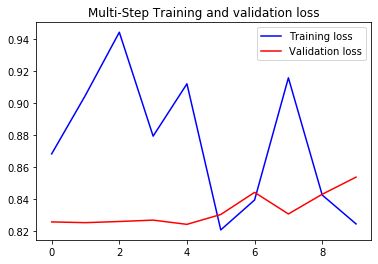

In [8]:
utils.plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

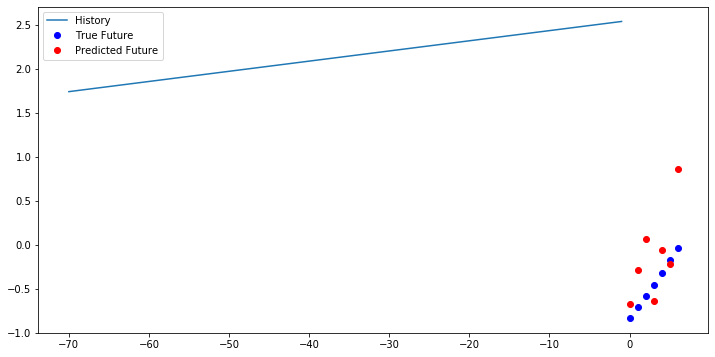

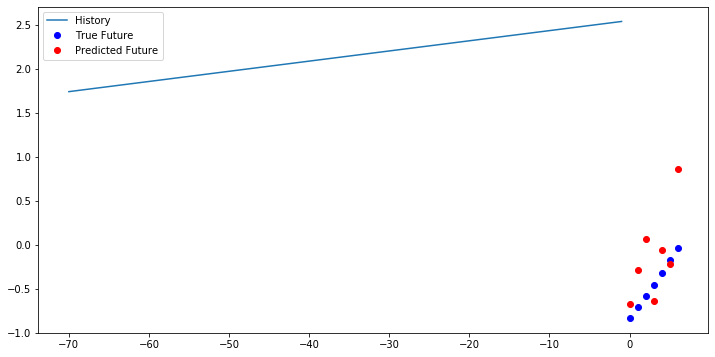

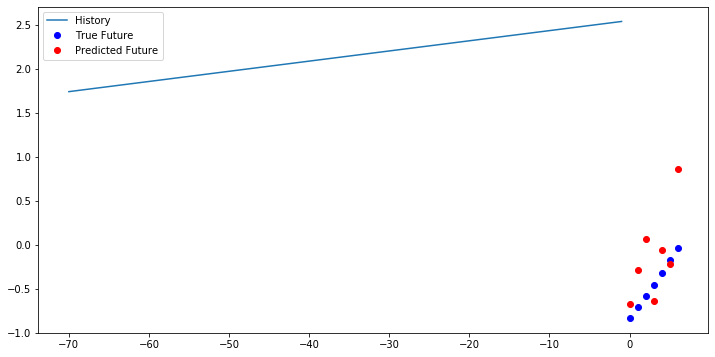

In [9]:
for x, y in val_data_multi.take(3):
  utils.multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], STEP)